In [85]:
from collections import Counter
from wordcloud import WordCloud
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt  # 형태소 분석기

In [86]:
client = MongoClient('mongodb://192.168.0.50')
db_name = client['DB_SGMN']
collection = db_name['COL_SCRAPPING_TOSS_COMMENT_HISTORY']

In [87]:
# 데이터 로드

find_data = collection.find()
toss_data = list(find_data)

In [88]:
df_toss_data = pd.DataFrame(toss_data)
df_toss_data.head(3)

,_id,COMMENT,CREATED_AT,DATE,DATETIME,SYMBOL,UPDATED_AT
0,675082d6239b5012b3c84a0b,머선일이야,2024-11-21 23:59:13.068,2024-11-22,2024-11-22T01:36:32+09:00,AADI,2024-11-21 23:58:33
1,675082d6239b5012b3c84a0c,뭐냐 너..왜 희망 갖게하냐,2024-11-21 23:59:13.068,2024-11-22,2024-11-22T01:07:42+09:00,AADI,2024-11-21 23:58:34
2,675082d6239b5012b3c84a0d,몇개월 기다리다가 조금 올라서 뺏더니 잘 올라가네.. ㅠ,2024-11-21 23:59:13.068,2024-11-22,2024-11-22T01:00:04+09:00,AADI,2024-11-21 23:58:34


In [89]:
df_toss_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251836 entries, 0 to 251835
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   _id         251836 non-null  object        
 1   COMMENT     251836 non-null  object        
 2   CREATED_AT  251836 non-null  datetime64[ns]
 3   DATE        251836 non-null  object        
 4   DATETIME    251836 non-null  object        
 5   SYMBOL      251836 non-null  object        
 6   UPDATED_AT  251836 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 13.4+ MB


In [90]:
# 3. CREATED_AT 필드 날짜 변환

# CREATED_AT을 datetime 형식으로 변환
df_toss_data['CREATED_AT'] = pd.to_datetime(df_toss_data['CREATED_AT'])

# 주 단위로 그룹화 준비 (연도-주 형식 추가)
df_toss_data['YEAR_WEEK'] = df_toss_data['CREATED_AT'].dt.strftime('%Y-%U')

In [91]:
it_sentence = df_toss_data['COMMENT'].values.tolist() # array list 로 변환 05번 it_sentence 변환 참조

In [92]:
# Okt 형태소 분석기를 사용하여 동사만 추출하는 함수

okt = Okt()

def extract_verbs(text):
    # 형태소 분석 후 동사만 필터링
    return [word for word, pos in okt.pos(text) if pos == 'Verb']

In [93]:
# 주 단위로 그룹화
grouped = df_toss_data.groupby('YEAR_WEEK')

In [94]:
# 주 단위로 TF-IDF 계산 및 워드클라우드 생성
for year_week, group in grouped:
    
    # 댓글을 하나의 리스트로 연결
    sentences = group['COMMENT'].dropna().tolist()
    
    # 동사만 추출하여 새로운 리스트에 저장
    verb_sentences = [' '.join(extract_verbs(comment)) for comment in it_sentence[:100]]

In [95]:
verb_sentences

['',
 '갖게하냐',
 '기다리다가 올라서 뺏더니 잘 올라가네',
 '갈까',
 '와 타사 할 하며 둔 하기 하여',
 '',
 '',
 '나도',
 '힘내라 힘내라',
 '가겠는데',
 '',
 '올라가',
 '',
 '는 갖고 모으기',
 '',
 '',
 '꾸 준매',
 '사러',
 '였네',
 '가자',
 '',
 '몰랐을까',
 '',
 '',
 '빌 빌',
 '뛰는데 날까',
 '모으는',
 '오르는 하더니',
 '줄여야지',
 '하냐',
 '모으',
 '나도 줄여야지',
 '떨어지네',
 '',
 '줄여야지',
 '',
 '시켜서 줄이는 쓰시나요 들고 가시나요',
 '보여줍시다',
 '',
 '',
 '나와주네요',
 '올라가요',
 '',
 '',
 '',
 '모르겠다',
 '내렸다가 올라가네요',
 '넣고',
 '하노',
 '갖고있는데',
 '떨어지지 않는다 올라가지 않는다',
 '',
 '할 했다 한 되는 가진 했다 이끄는 할 되어 덧붙였다 할 하는 얻었다 되었습니다 든 하는 되지 않습니다 되며 알려 드립니다',
 '',
 '',
 '짚으며 오를수 보였습니다 될 하며 짚었습니다 더디더라도 내려간다면 했습니다 들',
 '',
 '오르지도 않지만 내리지도 않아서 되는',
 '모아가는거',
 '겁나 잡았네',
 '찾아서',
 '던지지 한게 한이다',
 '',
 '나면 돼있어라',
 '했습니다 합니다',
 '',
 '',
 '달디 돼야지',
 '모으기',
 '지리더라구요',
 '',
 '오세요 갑니다',
 '',
 '이었어 힘내',
 '',
 '',
 '살거니까',
 '두자',
 '들어오면 되는거',
 '',
 '잡자',
 '했는데 할 심해진 허 밀릴 올리려는 짜치네 않다 사는',
 '봐 올릴 올림',
 '약해질까 하는거야',
 '',
 '',
 '',
 '되겠죠 들 파는거에요 잘 된건 모르겠어요',
 '들려주세요',
 '잘 먹고 갑니다',
 '',
 '',
 '재진 나을까요 모아가는 나을까요',
 '나가게',
 '떨구면 싶은데',
 '먹을게 올

In [96]:
# TF-IDF 벡터화

from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer()
tfidfVectorizer.fit(verb_sentences) # 학습용
result_vectors = tfidfVectorizer.transform(verb_sentences) # 서비스용

In [97]:
# TF-IDE 결과 확인

result_vectors.toarray().shape, tfidfVectorizer.get_feature_names_out().shape

((100, 121), (121,))

In [98]:
# 문장과 단어 vocab에 대한 매칭 관계 확인
tfidfVectorizer.get_feature_names_out(), result_vectors.toarray()[0]

(array(['가겠는데', '가시나요', '가자', '가진', '갈까', '갑니다', '갖게하냐', '갖고', '갖고있는데',
        '겁나', '기다리다가', '나가게', '나도', '나면', '나와주네요', '나을까요', '날까', '내려간다면',
        '내렸다가', '내리지도', '넣고', '달디', '더디더라도', '던지지', '덧붙였다', '돼야지', '돼있어라',
        '되겠죠', '되는', '되는거', '되며', '되어', '되었습니다', '되지', '된건', '두자', '드립니다',
        '들고', '들려주세요', '들어오면', '떨구면', '떨어지네', '떨어지지', '뛰는데', '먹고', '먹을게',
        '모르겠다', '모르겠어요', '모아가는', '모아가는거', '모으', '모으기', '모으는', '몰랐을까', '밀릴',
        '보니', '보여줍시다', '보였습니다', '뺏더니', '사는', '사러', '살거니까', '시켜서', '심해진',
        '싶은데', '쓰시나요', '않는다', '않다', '않습니다', '않아서', '않지만', '알려', '약해질까',
        '얻었다', '였네', '오르는', '오르지', '오르지도', '오를수', '오세요', '올라가', '올라가네',
        '올라가네요', '올라가요', '올라가지', '올라다오', '올라서', '올리려는', '올릴', '올림', '이끄는',
        '이었어', '잡았네', '잡자', '재진', '준매', '줄여야지', '줄이는', '지리더라구요', '짚었습니다',
        '짚으며', '짜치네', '찾아서', '타사', '파는거에요', '하기', '하냐', '하노', '하는', '하는거야',
        '하더니', '하며', '하여', '한게', '한이다', '합니다', '했는데', '했다', '했습니다', '힘내',
        '힘내라'], dtype=object),
 array(

In [99]:
# tfidf_scores = result_vectors.toarray().sum(axis=0) # 자료가 너무 많아 오류가 남으로 아래처럼 수정
tfidf_scores = result_vectors.toarray().sum(axis = 0)
tfidf_scores.shape

(121,)

In [100]:
# 5. 상위 20개 단어 선택
tfidf_ranking_20 = sorted(zip(tfidf_scores, tfidfVectorizer.get_feature_names_out())
                          , reverse = True)[:20]
tfidf_ranking_20

[(2.6834764565973352, '줄여야지'),
 (1.729972556523292, '나도'),
 (1.6761068036596087, '모으기'),
 (1.3522136073192175, '갑니다'),
 (1.007137468728489, '했습니다'),
 (1.0, '힘내라'),
 (1.0, '하노'),
 (1.0, '하냐'),
 (1.0, '찾아서'),
 (1.0, '지리더라구요'),
 (1.0, '준매'),
 (1.0, '잡자'),
 (1.0, '올라가요'),
 (1.0, '올라가'),
 (1.0, '오르지'),
 (1.0, '였네'),
 (1.0, '살거니까'),
 (1.0, '사러'),
 (1.0, '보여줍시다'),
 (1.0, '보니')]

In [101]:
# 딕셔너리 형태로 상위 20개 단어와 그 점수를 저장합니다.
top20_word = {word:score for score, word in tfidf_ranking_20}
top20_word

{'줄여야지': 2.6834764565973352,
 '나도': 1.729972556523292,
 '모으기': 1.6761068036596087,
 '갑니다': 1.3522136073192175,
 '했습니다': 1.007137468728489,
 '힘내라': 1.0,
 '하노': 1.0,
 '하냐': 1.0,
 '찾아서': 1.0,
 '지리더라구요': 1.0,
 '준매': 1.0,
 '잡자': 1.0,
 '올라가요': 1.0,
 '올라가': 1.0,
 '오르지': 1.0,
 '였네': 1.0,
 '살거니까': 1.0,
 '사러': 1.0,
 '보여줍시다': 1.0,
 '보니': 1.0}

In [102]:
wordCloud = WordCloud(background_color='white'
                      , font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')

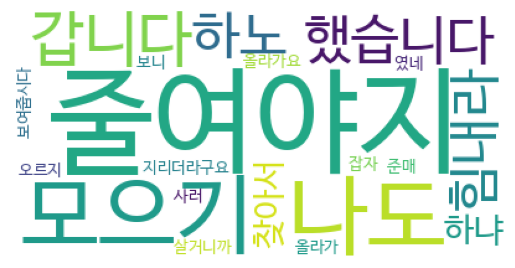

In [103]:
wordCloud.generate_from_frequencies(top20_word)

plt.imshow(wordCloud)
plt.axis('off')
plt.show()